In [0]:
import tensorflow as tf

import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

In [0]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [0]:
x_train = x_train / x_train.max()
x_test = x_test / x_test.max() 

In [0]:
inputs = tf.keras.layers.Input(shape = (28*28,))

## encoder 
enc_1 = tf.keras.layers.Dense(128, activation = "sigmoid")
enc_2_mean = tf.keras.layers.Dense(2)
enc_2_log_v = tf.keras.layers.Dense(2)

z_mean = enc_2_mean(enc_1(inputs))
z_log_v = enc_2_log_v(enc_1(inputs))

In [0]:
##sample from normal dist

def sampling(args):
    z_mean, z_log_v = args

    batch = tf.keras.backend.shape(z_mean)[0] ## this case 2
    dim = tf.keras.backend.int_shape(z_mean)[1] ## this case 1

    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) ## from Normal X Normal to smaple

    return z_mean + tf.keras.backend.exp(0.5 * z_log_v) * epsilon ## mean + sigma x

In [0]:
# Sampling function wrapped as a Keras layer

z = tf.keras.layers.Lambda(sampling, output_shape=(2,))([z_mean, z_log_v])

In [0]:
## decoder

z_input = tf.keras.layers.Input(shape = (2,))

dec_1 = tf.keras.layers.Dense(128, activation='sigmoid')
dec_2 = tf.keras.layers.Dense(784, activation='sigmoid')

outputs = dec_2(dec_1(z))


In [0]:
VAE = tf.keras.Model(inputs, outputs)

In [33]:
VAE.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          100480      input_5[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2)            258         dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            258         dense_12[1][0]             

In [0]:
## Loss

loss = 28*28* tf.keras.losses.mean_squared_error(inputs, outputs)


kl_loss = 1 + z_log_v - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_v)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = tf.keras.backend.mean(loss + kl_loss)

VAE.add_loss(vae_loss)

In [0]:
VAE.compile(tf.keras.optimizers.Adam())

In [42]:
VAE.fit(x_train, x_train, batch_size=256, epochs = 8)

Epoch 1/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6374
Epoch 2/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6330
Epoch 3/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6033
Epoch 4/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6070
Epoch 5/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6390
Epoch 6/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6127
Epoch 7/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6246
Epoch 8/8
235/235 [==============================] - 1s 3ms/step - loss: 26.6096


In [44]:
VAE_Encoder = tf.keras.Model(inputs, z_mean)

VAE_Encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 258       
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________


In [52]:
VAE_Encoder.predict(x_train[5:6])

array([[-1.3210305,  0.7534204]], dtype=float32)

In [0]:
indices = np.random.randint(x_train.shape[0], size=3000)

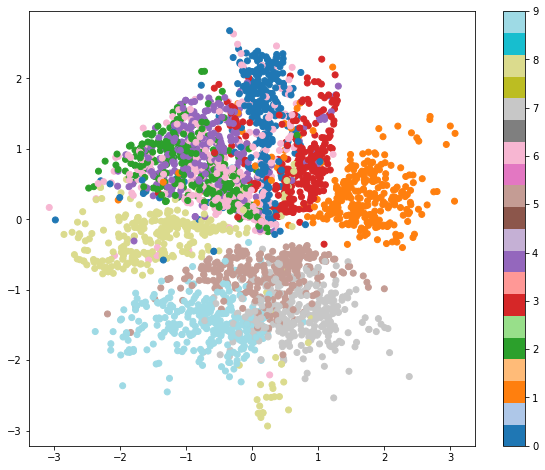

In [56]:
VAE_latents = VAE_Encoder.predict(x_train[indices])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train[indices], cmap='tab20')
plt.colorbar()
plt.show()